<a href="https://colab.research.google.com/github/crunchdomo/llm_conversation/blob/main/recipe_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install seaborn
!pip install statsmodels

In [2]:
import pandas as pd

df = pd.read_json('structured_recipes.json')


df['ingredient_count'] = df['ingredients'].apply(len)
df['step_count'] = df['instructions'].apply(lambda x: len(x) if isinstance(x, dict) else 0)



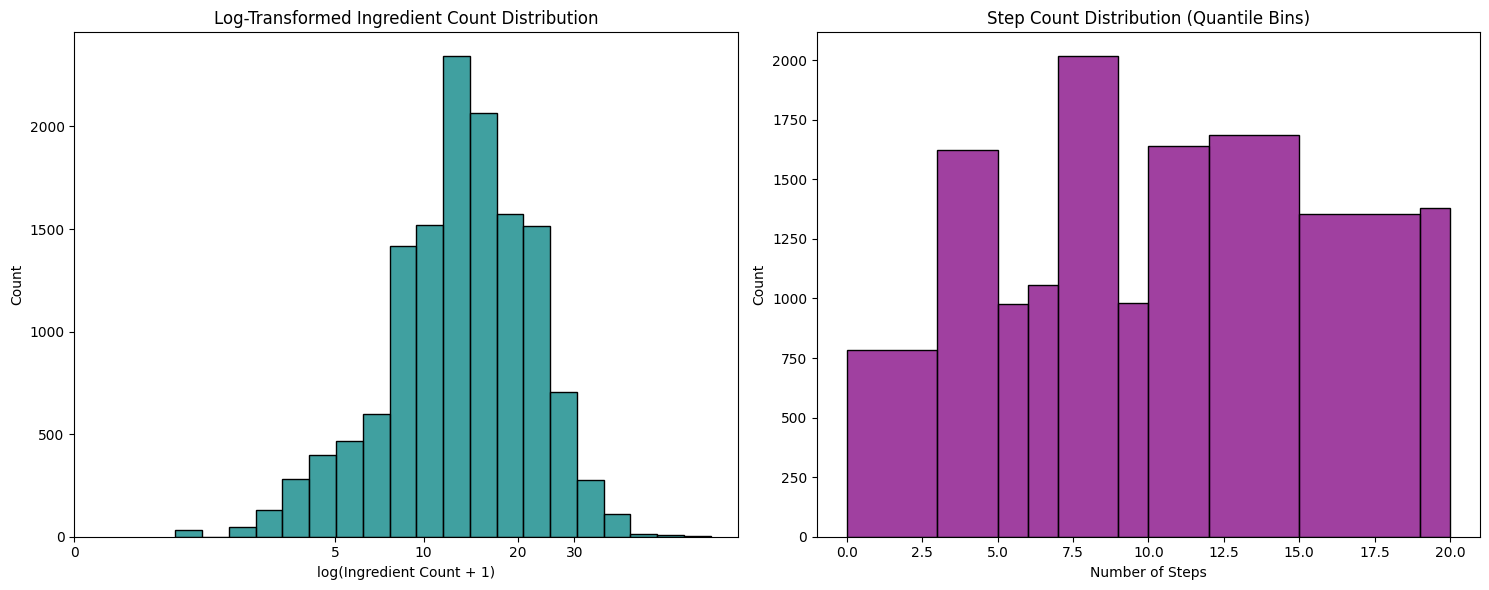

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 6))

# # Ingredient count histogram (no scale)
# plt.subplot(1, 2, 1)
# sns.histplot((df['ingredient_count']), bins=20, color='teal', kde=True)
# plt.title('Log-Transformed Ingredient Count Distribution')
# plt.xlabel('log(Ingredient Count + 1)')
# plt.xticks(np.log1p([0, 5, 10, 20, 30]), [0, 5, 10, 20, 30])


# Ingredient count histogram (log scale)
plt.subplot(1, 2, 1)
sns.histplot(np.log1p(df['ingredient_count']), bins=20, color='teal')
plt.title('Log-Transformed Ingredient Count Distribution')
plt.xlabel('log(Ingredient Count + 1)')
plt.xticks(np.log1p([0, 5, 10, 20, 30]), [0, 5, 10, 20, 30])

# Step count histogram (quantile bins)
plt.subplot(1, 2, 2)
step_bins = np.quantile(df['step_count'], np.linspace(0, 1, 11))
sns.histplot(df['step_count'], bins=step_bins, color='purple')
plt.title('Step Count Distribution (Quantile Bins)')
plt.xlabel('Number of Steps')

plt.tight_layout()
plt.show()


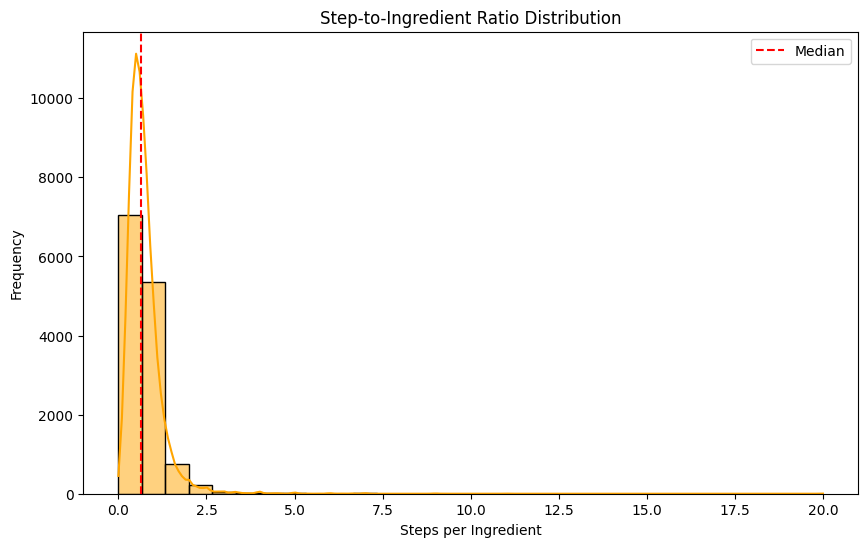

count    13501.000000
mean         0.734163
std          0.541313
min          0.000000
25%          0.434783
50%          0.631579
75%          0.888889
max         20.000000
Name: step_to_ingredient_ratio, dtype: float64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out recipes with zero ingredients to avoid division by zero
filtered_df = df[df['ingredient_count'] > 0].copy()

# Calculate the step-to-ingredient ratio
filtered_df['step_to_ingredient_ratio'] = filtered_df['step_count'] / filtered_df['ingredient_count']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['step_to_ingredient_ratio'], bins=30, kde=True, color='orange')
plt.title('Step-to-Ingredient Ratio Distribution')
plt.xlabel('Steps per Ingredient')
plt.ylabel('Frequency')
plt.axvline(filtered_df['step_to_ingredient_ratio'].median(), color='red', linestyle='--', label='Median')
plt.legend()
plt.show()

# Print basic statistics
print(filtered_df['step_to_ingredient_ratio'].describe())


In [5]:
df.head(
)

,title,ingredients,instructions,ingredient_count,step_count
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[['1 (3½–4-lb.) whole chicken', '2¾ tsp. koshe...","{'1': 'Pat chicken dry with paper towels, seas...",32,20
1,Crispy Salt and Pepper Potatoes,"[['2 large egg whites', '1 pound new potatoes ...",{'1': 'Preheat oven to 400°F and line a rimmed...,7,5
2,Thanksgiving Mac and Cheese,"[['240 ml evaporated milk', '240 ml whole milk...",{'1': 'Place a rack in middle of oven; preheat...,12,10
3,Italian Sausage and Bread Stuffing,"[['1 (¾- to 1-pound) round Italian loaf, cut i...",{'1': 'Preheat oven to 350°F with rack in midd...,23,15
4,Newton's Law,"[['5 ml dark brown sugar', '5 ml hot water', '...",{'1': 'Stir together brown sugar and hot water...,6,2


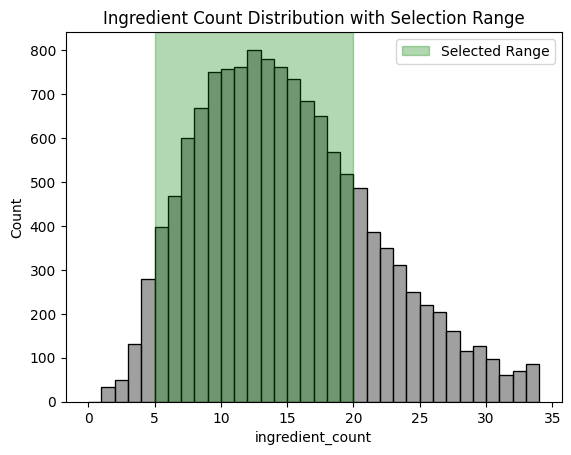

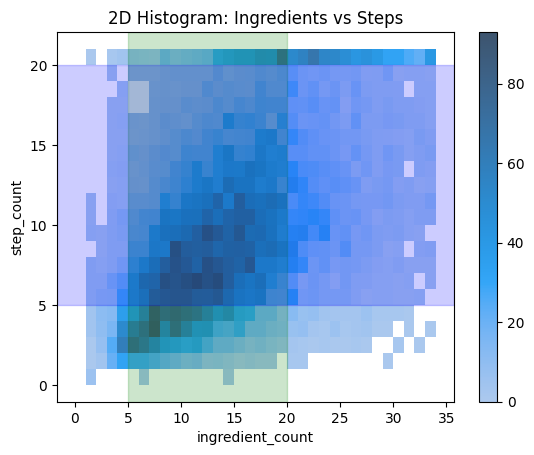

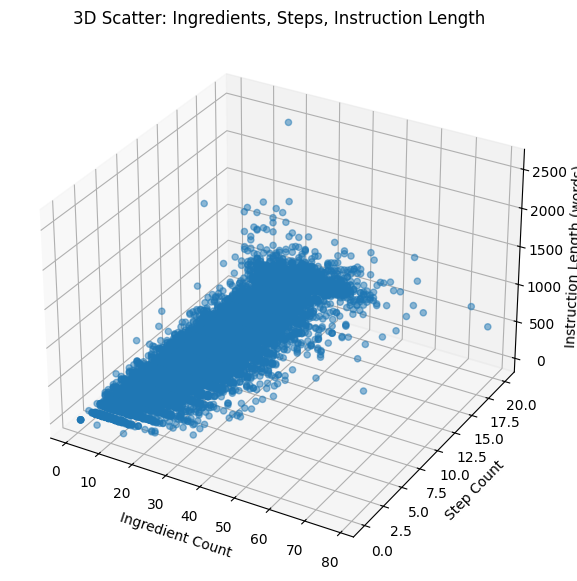

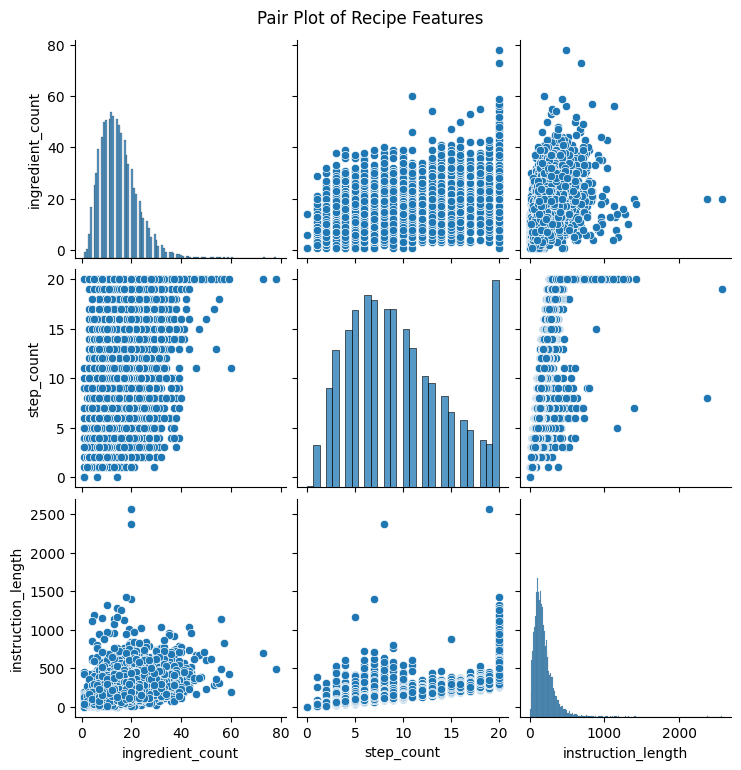

C:\Users\oenfa\AppData\Local\Temp\ipykernel_24208\3682246888.py:47: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='ingredient_bin', columns='step_bin', values='instruction_length', aggfunc='mean')


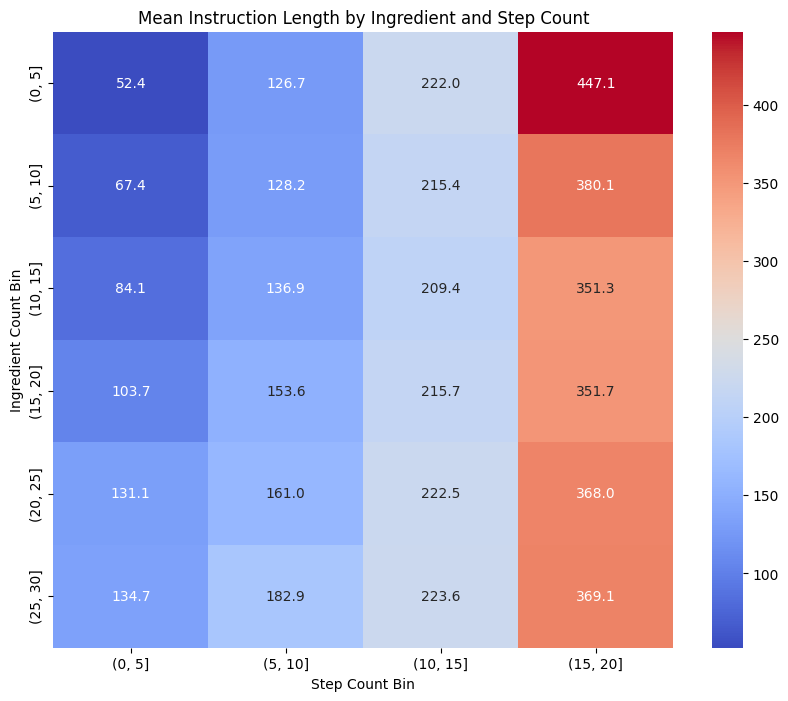

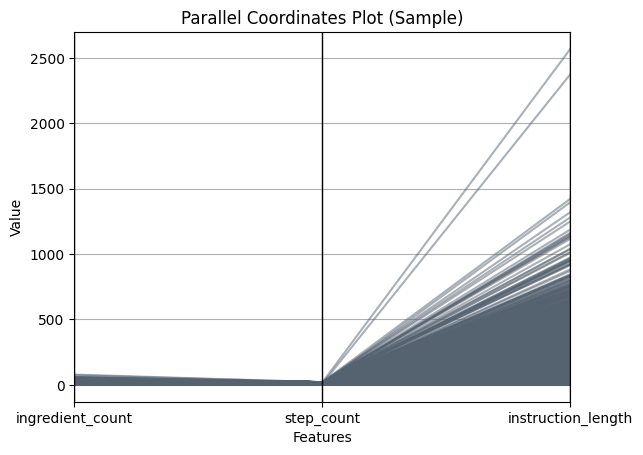

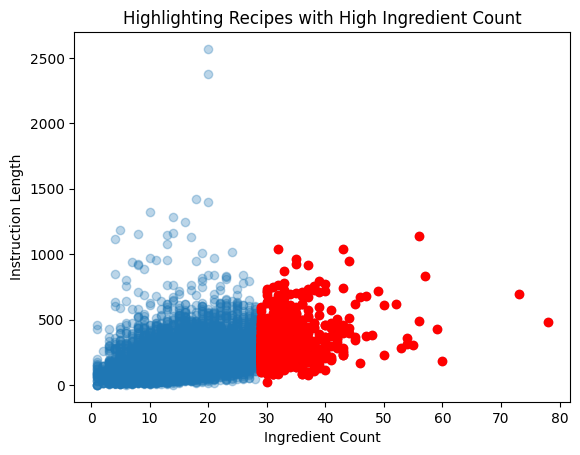

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df has columns 'ingredient_count' and 'step_count'
sns.histplot(df['ingredient_count'], bins=range(0, 35), color='grey')
plt.axvspan(5, 20, color='green', alpha=0.3, label='Selected Range')
plt.legend()
plt.title('Ingredient Count Distribution with Selection Range')
plt.show()

# 2D heatmap
sns.histplot(data=df, x='ingredient_count', y='step_count', bins=[range(0, 35), range(0, 22)], cbar=True)
plt.axvspan(5, 20, color='green', alpha=0.2)
plt.axhspan(5, 20, color='blue', alpha=0.2)
plt.title('2D Histogram: Ingredients vs Steps')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def extract_instruction_text(instruction_dict):
    if isinstance(instruction_dict, dict):
        return ' '.join(instruction_dict.values())
    return ''

df['instruction_text'] = df['instructions'].apply(extract_instruction_text)
df['instruction_length'] = df['instruction_text'].apply(lambda x: len(x.split()))


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['ingredient_count'], df['step_count'], df['instruction_length'], alpha=0.5)
ax.set_xlabel('Ingredient Count')
ax.set_ylabel('Step Count')
ax.set_zlabel('Instruction Length (words)')
plt.title('3D Scatter: Ingredients, Steps, Instruction Length')
plt.show()

import seaborn as sns
sns.pairplot(df[['ingredient_count', 'step_count', 'instruction_length']])
plt.suptitle('Pair Plot of Recipe Features', y=1.02)
plt.show()

import pandas as pd
df['ingredient_bin'] = pd.cut(df['ingredient_count'], bins=range(0, 35, 5))
df['step_bin'] = pd.cut(df['step_count'], bins=range(0, 22, 5))
pivot = df.pivot_table(index='ingredient_bin', columns='step_bin', values='instruction_length', aggfunc='mean')
plt.figure(figsize=(10,8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Mean Instruction Length by Ingredient and Step Count')
plt.xlabel('Step Count Bin')
plt.ylabel('Ingredient Count Bin')
plt.show()

from pandas.plotting import parallel_coordinates

sample_df = df[['ingredient_count', 'step_count', 'instruction_length']].copy()
sample_df['index'] = sample_df.index.astype(str)
parallel_coordinates(sample_df, 'index', color=('#556270',), alpha=0.5)
plt.title('Parallel Coordinates Plot (Sample)')
plt.xlabel('Features')
plt.ylabel('Value')
plt.legend([],[], frameon=False)
plt.show()

# Highlight recipes with high ingredient count
high_ingredients = df[df['ingredient_count'] > df['ingredient_count'].quantile(0.95)]
plt.scatter(df['ingredient_count'], df['instruction_length'], alpha=0.3)
plt.scatter(high_ingredients['ingredient_count'], high_ingredients['instruction_length'], color='red')
plt.xlabel('Ingredient Count')
plt.ylabel('Instruction Length')
plt.title('Highlighting Recipes with High Ingredient Count')
plt.show()


In [ ]:
filtered_df = df[
    (df['ingredient_count'] >= 3) & (df['ingredient_count'] <= 20) &
    (df['step_count'] >= 3) & (df['step_count'] <= 20)
]
print(f"Filtered recipes: {len(filtered_df)} / {len(df)}")


Filtered recipes: 10044 / 13501


In [ ]:
# Filter to reasonable ranges based on your histograms
filtered_df = df[
    (df['ingredient_count'] >= 5) & (df['ingredient_count'] <= 20) &
    (df['step_count'] >= 3) & (df['step_count'] <= 15)
]
print(f"Filtered recipes: {len(filtered_df)} / {len(df)}")


Filtered recipes: 8573 / 13501
